In [1]:
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import KFold
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(suppress=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

from IPython.display import clear_output

import json

In [2]:
MODEL_FILE = "3.4. Esembler_RandomForest_PA_IP.json"

In [3]:
# Random Forest
TREE_PARAMS = {
    "max_depth": 13,
    "min_samples_leaf": 15,
    "n_estimators": 1100,
    "random_state": 0,
    "n_jobs": -1
}

In [4]:
path1 = Path(r"A:\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")
path2 = Path(r"C:\Users\rober\Documents\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")

if path1.is_dir():
    DATASET_DIR = path1
else:
    DATASET_DIR = path2

In [5]:
# Check if Models exists

In [6]:
model_path = DATASET_DIR / "Models" / MODEL_FILE
MODEL_EXIST = model_path.is_file()

In [7]:
# Daten

In [8]:
app_train = pd.read_csv(DATASET_DIR / "4. FillNA" / "application.csv")
pa_ip = pd.read_csv(DATASET_DIR / "4. FillNA" / "pa_ip.csv")
app_train = app_train.set_index("SK_ID_CURR")
pa_ip = pa_ip.set_index("SK_ID_CURR")

In [9]:
pa_ip.head()

,PA_CNT_CREDITS,PA_IP_PAYMENT_30,PA_IP_DAYS_DIFF_30,PA_IP_AMT_DIFF_30,PA_IP_PAYMENT_60,PA_IP_DAYS_DIFF_60,PA_IP_AMT_DIFF_60,PA_IP_PAYMENT_90,PA_IP_DAYS_DIFF_90,PA_IP_AMT_DIFF_90,PA_IP_PAYMENT_120,PA_IP_DAYS_DIFF_120,PA_IP_AMT_DIFF_120,PA_IP_PAYMENT_150,PA_IP_DAYS_DIFF_150,PA_IP_AMT_DIFF_150,PA_IP_PAYMENT_180,PA_IP_DAYS_DIFF_180,PA_IP_AMT_DIFF_180,PA_AMT_ANNUITY,PA_AMT_APPLICATION,PA_AMT_CREDIT,PA_AMT_DOWN_PAYMENT,PA_AMT_GOODS_PRICE,PA_RATE_DOWN_PAYMENT,PA_CNT_NAME_CONTRACT_TYPE_Revolving loans,PA_CNT_NAME_CONTRACT_STATUS_Refused,PA_CNT_CODE_REJECT_REASON_HC,PA_CNT_NAME_CLIENT_TYPE_New,PA_CNT_NAME_CLIENT_TYPE_Refreshed,PA_CNT_NAME_PORTFOLIO_Cards,PA_CNT_NAME_PRODUCT_TYPE_walk-in,PA_CNT_NAME_YIELD_GROUP_high,PA_CNT_NAME_YIELD_GROUP_low_normal,PA_CNT_PRODUCT_COMBINATION_Card Street,PA_CNT_PRODUCT_COMBINATION_Cash X-Sell: low,PA_CNT_PRODUCT_COMBINATION_POS industry with interest
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
252457,1.0,-9.128709e-01,0.0,0.0,9.128709e-01,-15.0,0.0,9.128709e-01,-17.0,0.0,0.912871,-14.0,0.0,-0.912871,0.0,0.0,-0.912871,0.0,0.0,4951.350,47056.275,52641.0,4.275,47056.275,0.000088,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
256657,2.0,2.041241e-01,-6.0,0.0,2.041241e-01,-13.0,0.0,2.041241e-01,-12.0,0.0,0.204124,-12.5,0.0,0.204124,-13.0,0.0,-1.020621,-1.5,0.0,49054.770,978570.000,1198062.0,15714.000,978570.000,0.217818,2.0,7.0,5.0,1.0,0.0,2.0,5.0,0.0,2.0,1.0,0.0,0.0
198678,2.0,4.540312e-08,-20.0,0.0,4.540312e-08,-21.5,0.0,4.540312e-08,-6.5,0.0,-0.000407,-1.0,0.0,0.000204,0.5,0.0,0.000204,-0.5,0.0,98806.050,921721.500,941661.0,13347.000,921721.500,0.193358,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394447,2.0,5.295619e-01,-0.5,0.0,6.115381e-01,-7.0,0.0,-3.183548e-01,-7.0,0.0,-0.229629,-6.5,0.0,-0.180184,-8.5,0.0,-0.412932,0.0,0.0,17141.445,129132.000,129132.0,0.000,129132.000,0.000000,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
156331,2.0,-7.381905e-01,0.0,0.0,1.416426e-02,0.0,0.0,1.416426e-02,0.0,0.0,-1.114368,-1.0,0.0,1.207845,-12.5,0.0,0.616385,-5.0,0.0,40866.795,793035.000,793035.0,0.000,793035.000,0.000000,2.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0


In [10]:
# Ermittlung Reihenfolge

In [11]:
y = app_train.loc[pa_ip.index]["TARGET"]
x = pa_ip

In [12]:
if not MODEL_EXIST:
    # unterteilt den trainingsdatensatz in trainings- und validierungsdatensätze
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5, random_state=0)

    # logistisches Regressionsmodell
    model = RandomForestClassifier(**TREE_PARAMS)
    model.fit(x_train, y_train)

    auc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    print(auc)

    # Koeffizienten der einzelnen Klassen
    coef_dict = {}
    for coef, feat in zip(model.feature_importances_, x.columns.values):
        coef_dict[feat] = coef

    # Feature Importance
    d = dict(sorted(coef_dict.items(), key=lambda item: item[1], reverse=True))
    order = list(d.keys())
    
    model_data = {
    "todo" : order,
    "keep" : [],
    "drop" : [],
    "params" : TREE_PARAMS,
    "auc" : [],
    "p" : [],
    "n" : []
    }
    
    auc_temp = 0.5

In [13]:
if MODEL_EXIST:
    with open(DATASET_DIR / "Models" / MODEL_FILE, 'r') as file:
        model_data = json.load(file)
    auc_temp = model_data["auc"][-1]

In [14]:
#Entscheidungsbaum Parameterbestimmung

In [15]:
df = pa_ip

print('auc: %s, todo: %s, keep: %s, drop: %s' % (round(auc_temp,4), len(model_data["todo"]), len(model_data["keep"]), len(model_data["drop"])))
todo = model_data["todo"].copy()

for head in todo:
    
    model_data["keep"].append(head)
    
    X = df[model_data["keep"]]
    y = app_train.loc[pa_ip.index]["TARGET"]
    x = X
    
    model = RandomForestClassifier(**TREE_PARAMS).fit(x, y)
    
    aucs = []

    kfold = KFold(5, shuffle=True, random_state=1)

    for train, test in kfold.split(x):
        model.fit(x.iloc[train], y.iloc[train])
        auc = roc_auc_score(y.iloc[test], model.predict_proba(x.iloc[test])[:,1])
        aucs.append(auc)
    
    auc = np.mean(aucs)
    n = len(X)
    p = len(X.columns)
    
    if auc > auc_temp:
        
        model_data["auc"].append(auc)
        model_data["p"].append(p)
        model_data["n"].append(n)
        
        auc_temp = auc
        
    else:
        model_data["keep"].remove(head)
        model_data["drop"].append(head)
    
    model_data["todo"].remove(head)
    
    with open(DATASET_DIR / "Models" / MODEL_FILE, 'w') as file:
        json.dump(model_data, file)
        
    clear_output(wait=True)
    print('auc: %s, todo: %s, keep: %s, drop: %s' % (round(auc,4), len(model_data["todo"]), len(model_data["keep"]), len(model_data["drop"])))

auc: 0.6362, todo: 0, keep: 27, drop: 10


         auc   p       n
26  0.636191  27  179175


<AxesSubplot:>

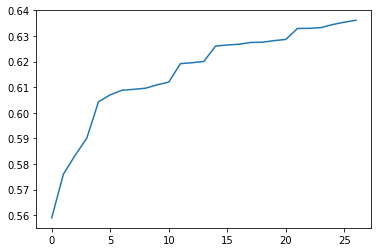

In [16]:
data = {
    "auc" : model_data["auc"],
    "p" : model_data["p"],
    "n" : model_data["n"]
}

result = pd.DataFrame(data)

print(result[result["auc"] == result["auc"].max()])
result["auc"].plot()

In [17]:
model_data["keep"]

['PA_CNT_NAME_PRODUCT_TYPE_walk-in',
 'PA_IP_DAYS_DIFF_60',
 'PA_CNT_NAME_CONTRACT_STATUS_Refused',
 'PA_IP_DAYS_DIFF_30',
 'PA_AMT_ANNUITY',
 'PA_IP_DAYS_DIFF_120',
 'PA_IP_DAYS_DIFF_90',
 'PA_IP_DAYS_DIFF_180',
 'PA_AMT_CREDIT',
 'PA_IP_PAYMENT_180',
 'PA_AMT_APPLICATION',
 'PA_IP_AMT_DIFF_60',
 'PA_IP_AMT_DIFF_30',
 'PA_IP_DAYS_DIFF_150',
 'PA_CNT_NAME_YIELD_GROUP_low_normal',
 'PA_CNT_PRODUCT_COMBINATION_Cash X-Sell: low',
 'PA_IP_PAYMENT_60',
 'PA_IP_AMT_DIFF_180',
 'PA_IP_AMT_DIFF_90',
 'PA_CNT_NAME_CONTRACT_TYPE_Revolving loans',
 'PA_IP_AMT_DIFF_150',
 'PA_CNT_NAME_CLIENT_TYPE_New',
 'PA_CNT_NAME_YIELD_GROUP_high',
 'PA_CNT_NAME_PORTFOLIO_Cards',
 'PA_CNT_NAME_CLIENT_TYPE_Refreshed',
 'PA_CNT_PRODUCT_COMBINATION_POS industry with interest',
 'PA_RATE_DOWN_PAYMENT']

In [18]:
model_data["drop"]

['PA_AMT_GOODS_PRICE',
 'PA_IP_PAYMENT_150',
 'PA_CNT_PRODUCT_COMBINATION_Card Street',
 'PA_IP_PAYMENT_90',
 'PA_IP_PAYMENT_120',
 'PA_IP_PAYMENT_30',
 'PA_CNT_CODE_REJECT_REASON_HC',
 'PA_IP_AMT_DIFF_120',
 'PA_CNT_CREDITS',
 'PA_AMT_DOWN_PAYMENT']

In [19]:
model = RandomForestClassifier(**TREE_PARAMS)

TPRs = []
TNRs = []
Ps = []
NPVs = []
Fs = []
As = []
aucs = []

kfold = KFold(5, shuffle=True, random_state=1)

X = df[model_data["keep"]]
y = app_train.loc[pa_ip.index]["TARGET"]
x = X

for ID_TRAIN, ID_TEST in kfold.split(x):
    
    x_train = x.iloc[ID_TRAIN]
    y_train = y.iloc[ID_TRAIN]
    x_test = x.iloc[ID_TEST]
    y_test = y.iloc[ID_TEST]
    
    model.fit(x_train, y_train)
    (tn,fp),(fn,tp)=confusion_matrix(y_test, model.predict(x_test))
    
    # TPR
    TPR = R = tp/(tp+fn)
    # TNR
    TNR = tn/(tn+fp)
    # Precision
    P = tp/(tp+fp)
    # NPV
    NPV = tn/(tn+fn)
    # F-Score
    F = 2*P*R/(P+R)
    # Accuracy
    A = (tp+tn)/(tp+tn+fp+fn)
    # AUC
    auc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
    
    TPRs.append(TPR)
    TNRs.append(TNR)
    Ps.append(P)
    NPVs.append(NPV)
    Fs.append(F)
    As.append(A)
    aucs.append(auc)
    
    print('TPR: %.4f' % TPR, 'TNR: %.4f' % TNR, 'P: %.4f' % P, 'NPV: %.4f' % NPV, 'F: %.4f' % F, 'Accuracy: %.4f' % A, 'AUC: %.4f' % auc)

print("\n")
print("Durchschnitte:")
print('TPR: %.4f' % np.mean(TPRs), 'TNR: %.4f' % np.mean(TNRs), 'P: %.4f' % np.mean(Ps), 'NPV: %.4f' % np.mean(NPVs), 'F: %.4f' % np.mean(Fs), 'Accuracy: %.4f' % np.mean(As), 'AUC: %.4f' % np.mean(aucs))

<ipython-input-19-e833aaa95d2d>:32: RuntimeWarning: invalid value encountered in longlong_scalars
  P = tp/(tp+fp)


TPR: 0.0000 TNR: 1.0000 P: nan NPV: 0.9195 F: nan Accuracy: 0.9195 AUC: 0.6402


<ipython-input-19-e833aaa95d2d>:32: RuntimeWarning: invalid value encountered in longlong_scalars
  P = tp/(tp+fp)


TPR: 0.0000 TNR: 1.0000 P: nan NPV: 0.9172 F: nan Accuracy: 0.9172 AUC: 0.6512


<ipython-input-19-e833aaa95d2d>:32: RuntimeWarning: invalid value encountered in longlong_scalars
  P = tp/(tp+fp)


TPR: 0.0000 TNR: 1.0000 P: nan NPV: 0.9191 F: nan Accuracy: 0.9191 AUC: 0.6466


<ipython-input-19-e833aaa95d2d>:32: RuntimeWarning: invalid value encountered in longlong_scalars
  P = tp/(tp+fp)


TPR: 0.0000 TNR: 1.0000 P: nan NPV: 0.9197 F: nan Accuracy: 0.9197 AUC: 0.6515


<ipython-input-19-e833aaa95d2d>:32: RuntimeWarning: invalid value encountered in longlong_scalars
  P = tp/(tp+fp)


TPR: 0.0000 TNR: 1.0000 P: nan NPV: 0.9198 F: nan Accuracy: 0.9198 AUC: 0.6501


Durchschnitte:
TPR: 0.0000 TNR: 1.0000 P: nan NPV: 0.9191 F: nan Accuracy: 0.9191 AUC: 0.6479
